# Notebook to reproduce the Stereo Calibration using the dataset of Gunady et al.

Guandy et al. provided an [image set](https://doi.org/10.34770/d79j-dw71) which we used to show the applicability of our laser cross detection method in volumetric camera calibration. An example image is shown here:

![](./assets/guandy_example_image.png) 
_Adapted from: [Gunady et al. 2024](https://doi.org/10.34770/d79j-dw71)_

The detected point of intersection is marked by a red cross. We used the following
parameter setup for the detection and processed all images for both cameras:  
```python
import laser_cross_detection as lcd

method = lcd.core.Kluwe(
    start_angle=-45, 
    angle_range=90, 
    angle_steps=180, 
    beam_width=85
    )
for image in tqdm(image_set1, desc="camera 1"):
    intersection = method(image)
    ...
```

The results are stored in the files './data/camera1_detections.txt' and './data/camera2_detections.txt' together with the physical coordinates $(x, y, z)$ of the respective point in the calibration pattern. Knowing the physical positions $x, y, z$ each camera can be calibrated using the detected intersections in the respective image plane.

## Loading camera detections

In [2]:
# insert top level directory to path for importing the laser_cross_detection module
import sys
sys.path.insert(0, "..")

import laser_cross_detection as lcd

import matplotlib.pyplot as plt

# scaling factor in y direction for physical space, provided by Gunady et al.
SNELL_FACTOR = 1.34

cam1_calibration = lcd.calibration.CameraCalibrationSet.from_path(
    "./data/gunady_camera1_detections.txt", y_scale=SNELL_FACTOR
)
cam2_calibration = lcd.calibration.CameraCalibrationSet.from_path(
    "./data/gunady_camera2_detections.txt",  y_scale=SNELL_FACTOR
)


fig, ax = plt.subplots(1, 2, sharey=True, sharex=True)
fig.suptitle("Detected Laser Cross Intersections")
ax[0].set_title("camera 1")
ax[0].set_xlabel(r"$u$ in px")
ax[0].set_ylabel(r"$v$ in px")
ax[0].scatter(
    *cam1_calibration.uv.T,
    color=plt.cm.jet(cam1_calibration.y / cam1_calibration.y.max()),
    alpha=0.5,
    s=7
)

ax[1].set_title("camera 2")
ax[1].set_xlabel(r"$u$ in px")
ax[1].scatter(
    *cam2_calibration.uv.T,
    color=plt.cm.jet(cam2_calibration.y / cam2_calibration.y.max()),
    alpha=0.5,
    s=7
)
[a.set_aspect("equal") for a in ax];

FileNotFoundError: [Errno 2] No such file or directory: './data/guandy_camera1_detections.txt'

## Creating Camera Calibrations

To increase the robustness a two staged procedure is used. First an initial guess for the point $(x, y, z)$ in physical space is made using a Soloff Polynomial of type 111. This point is used as the initial condition for the calibration with higher order polynomials, e. g. 333.

### Order 111 Calibration

In [ ]:
# create 1, 1, 1 calibration to provide initial starting point for higher
# order polynomial
init_cc1 = lcd.calibration.SoloffCamCalibration.from_clibration_points(
    xyz = cam1_calibration.xyz,
    u = cam1_calibration.u,
    v = cam1_calibration.v,
    soloff_type=(1, 1, 1),
)
init_cc2 = lcd.calibration.SoloffCamCalibration.from_clibration_points(
    xyz = cam2_calibration.xyz,
    u = cam2_calibration.u,
    v = cam2_calibration.v,
    soloff_type=(1, 1, 1),
)

init_smcc = lcd.calibration.SoloffMultiCamCalibration([init_cc1, init_cc2])

### Order 332 Calibration

In [ ]:
# actual 3, 3, 2 calibration used
cc1 = lcd.calibration.SoloffCamCalibration.from_clibration_points(
    cam1_calibration.xyz,
    cam1_calibration.u,
    cam1_calibration.v,
    soloff_type=(3, 3, 2),
)
cc2 = lcd.calibration.SoloffCamCalibration.from_clibration_points(
    cam2_calibration.xyz,
    cam2_calibration.u,
    cam2_calibration.v,
    soloff_type=(3, 3, 2),
)

smcc = lcd.calibration.SoloffMultiCamCalibration([cc1, cc2])

### Reconstructing Calibration Pattern from Image Data

In [ ]:
points = []
for u1, u2, v1, v2 in zip(
    cam1_calibration.u,
    cam2_calibration.u,
    cam1_calibration.v,
    cam2_calibration.v,
):
    x0 = init_smcc.calculate_point(us=[u1, u2], vs=[v1, v2], x0=(1, 1, 1))
    points.append(smcc.calculate_point(us=[u1, u2], vs=[v1, v2], x0=x0))

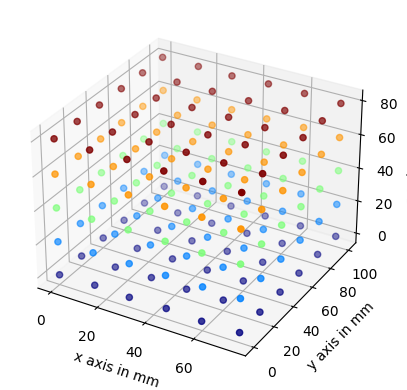

In [ ]:
ax = plt.figure().add_subplot(projection="3d")
ax.set_xlabel("x axis in mm")
ax.set_ylabel("y axis in mm")
ax.set_zlabel("z axis in mm")
ax.scatter(*np.array(points).T, color=plt.cm.jet(cam1_calibration.z/cam1_calibration.z.max()));

### Reprojection Error
Calculating the reprojection error by projecting the detected physical coordinates of the calibration pattern back onto the image plane of the respective camera and measuring the distance to the actual image coordinates of the calibration pattern.

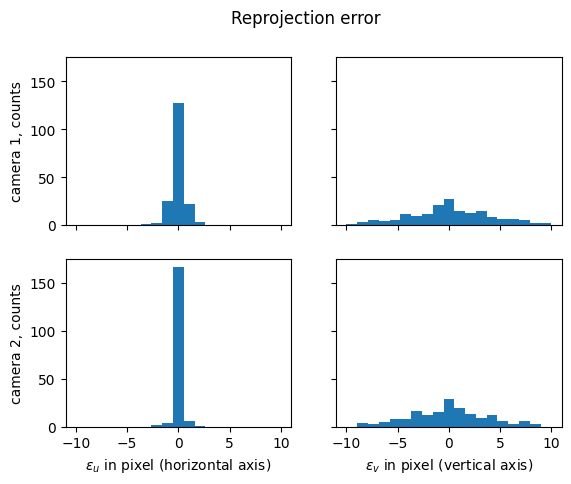

In [ ]:
(u1, v1), (u2, v2) = smcc(points)

bins = np.linspace(-10, 10, 20)
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig.suptitle("Reprojection error")
ax[0,0].set_ylabel("camera 1, counts")
ax[0, 0].hist(cam1_calibration.u - u1, bins=bins)
ax[0, 1].hist(cam1_calibration.v - v1, bins=bins)
ax[1,0].set_ylabel("camera 2, counts")
ax[1, 0].set_xlabel(r"$\epsilon_u$ in pixel (horizontal axis)")
ax[1, 0].hist(cam2_calibration.u - u2, bins=bins)
ax[1, 1].hist(cam2_calibration.v - v2, bins=bins)
ax[1, 1].set_xlabel(r"$\epsilon_v$ in pixel (vertical axis)");

## Reconstructing the calibration Target

Guandy et al. provided an image pair set showing a defined hardware calibration target captured with their stereo setup. Since the dimension of the target (point pattern on the target) is known, it can be used to validate the camera calibration. We detected the centers of the points of the pattern using the `skimage.filters.threshold_otsu` and `skimage.measure.label` functions of the _scikit-image_ Python library. The extracted coordinates are stored in the `./data/targets.npz` `numpy`-archive. The top grid is referred to as "grid1" and the bottom grid as "grid2". However, in the following only the top grid is considered. 

![](./assets/guandy_target_detected.png)
_Adapted from: [Guandy et al. 2024](https://doi.org/10.34770/d79j-dw71)_

[INFO] cam1 gridpoints: 120
[INFO] cam2 gridpoints: 120


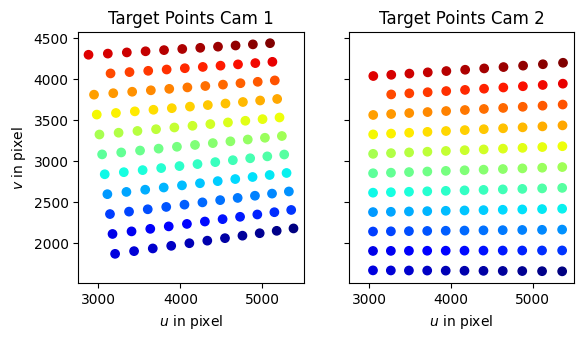

In [ ]:
grids = np.load("./data/targets.npz")
cam1grid1 = grids["cam1grid1"]
cam2grid1 = grids["cam2grid1"]

print(f"[INFO] cam1 gridpoints: {len(cam1grid1)}")
print(f"[INFO] cam2 gridpoints: {len(cam2grid1)}")

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
ax[0].set_title("Target Points Cam 1")
ax[0].set_ylabel("$v$ in pixel")
ax[0].set_xlabel("$u$ in pixel")
ax[0].scatter(*cam1grid1.T, color=plt.cm.jet(np.linspace(0, 1, 120)))

ax[1].set_title("Target Points Cam 2")
ax[1].set_xlabel("$u$ in pixel")
ax[1].scatter(*cam2grid1.T, color=plt.cm.jet(np.linspace(0, 1, 120)))
[a.set_aspect("equal") for a in ax];

Calculate $(x, y, z)$ coordinates from $(u, v)$ image pairs.

In [ ]:
grid_points = []

for (u1, v1), (u2, v2) in zip(cam1grid1, cam2grid1):
    # initial guess with 111 order calibration
    x0 = init_smcc.calculate_point(us=[u1, u2], vs=[v1, v2], x0=(1, 1, 1))
    # final detection using 332 order calibration
    grid_points.append(smcc.calculate_point(us=[u1, u2], vs=[v1, v2], x0=x0))

Visualize reconstructed point grid.

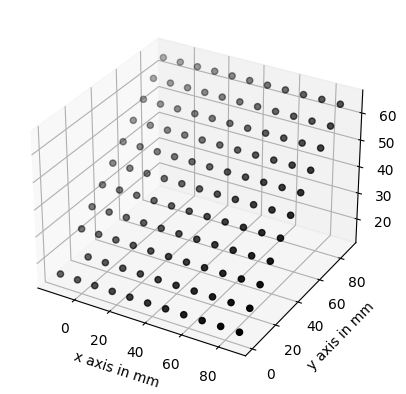

In [ ]:
ax = plt.figure().add_subplot(projection="3d")

ax.set_xlabel("x axis in mm")
ax.set_ylabel("y axis in mm")
ax.set_zlabel("z axis in mm")
ax.scatter(*np.array(grid_points).T, c="black");

Estimate accuracy by aligning reconstructed points to a planar grid. Therefor we choose the points along the central axes of the target and calculate their main orientation using a singular value decomposition (SVD).

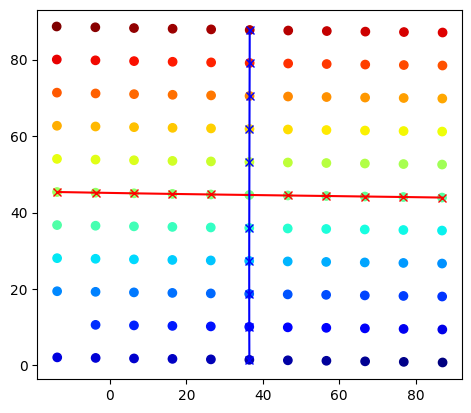

In [ ]:
# convert grid point list to numpy array
grid_point_array = np.array(grid_points)

# sort grid points by indices to make sure the point order is correct
ind = np.lexsort([grid_point_array[:,0], grid_point_array[:, 1]])
grid_point_array = grid_point_array[ind]

# selecting points on central axes of target
# horizontal and vertical axes
axis1 = grid_point_array[[64, 63, 62, 61, 60, 58, 57, 56, 55, 54], :]
axis2 = grid_point_array[[114, 103, 92, 81, 70, 48, 37, 26, 16, 5], :]

# diagonal axes
# axis1 = grid_point_array[[0, 12, 23, 35, 47, 71, 83, 95, 107, 119], :]
# axis2 = grid_point_array[[10, 20, 29, 39, 49, 69, 79, 89, 99, 109], :]

# visualize sorted points and main axes
fig, ax = plt.subplots()
ax.scatter(*grid_point_array[:, :2].T, c=plt.cm.jet(np.linspace(0, 1, 120)))
ax.plot(*axis1[:, :2].T, c="r", marker="x")
ax.plot(*axis2[:, :2].T, c="b", marker="x")
ax.set_aspect("equal")

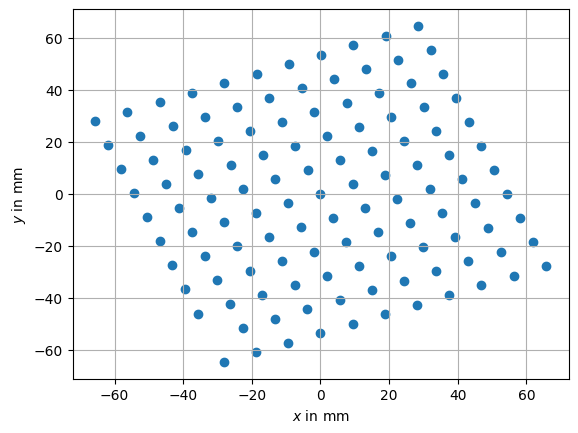

In [ ]:
# concatenate points
axis = np.concatenate([axis1, axis2])

# calculate mean to center point cloud at origin of the coordinate system
axis_mean = axis.mean(axis=0)

# subtract mean from grid points and axes
grid_point_array -= axis_mean
axis -= axis_mean

# calculate the svd
uu, dd, vv = np.linalg.svd(axis)

# transform the points using main components of svd
x, y, z = np.dot(vv, grid_point_array.T)

# show result
fig, ax = plt.subplots()
ax.set_xlabel(r"$x$ in mm")
ax.set_ylabel(r"$y$ in mm")
ax.scatter(x, y)
ax.grid()

The resulting point cloud is not aligned with the main axes of the coordinate system. It is therefor rotated by an angle minimizing the deviation to the planor orthogonal grid. 

Maximum deviation:  0.6282407594294028 
 Mean deviation:    0.2225505235235981


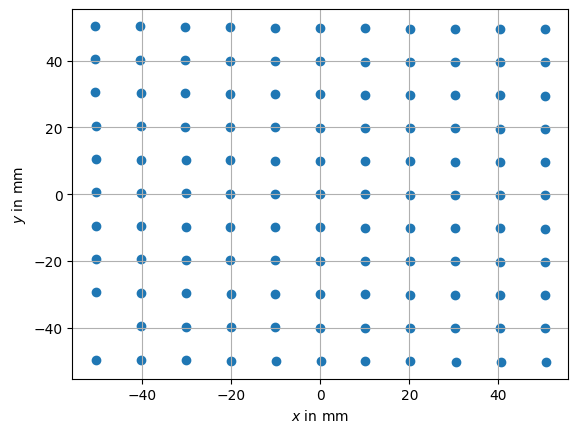

In [ ]:
# transform points to polar space for easier rotation
r, phi = np.hypot(x, y), np.arctan2(y, x)
# rotate by adding to phi coordinate
phi += np.deg2rad(
    -21.9
)  # angle is chosen to minimize maximum deviation from actual grid
# transform back to cartesian space
xx, yy = r * np.cos(phi), r * np.sin(phi)

# visualize results
fig, ax = plt.subplots()
ax.set_xlabel(r"$x$ in mm")
ax.set_ylabel(r"$y$ in mm")
ax.scatter(xx, yy)
ax.grid()

# calculate deviation from actual planar grid on hardware target
xs = np.linspace(-50, 50, 11)
xdist = []
for p in xx:
    xdist.append(p - xs[np.argmin(np.abs(xs - p))])

ydist = []
for p in yy:
    ydist.append(p - xs[np.argmin(np.abs(xs - p))])

print(
    "Maximum deviation: ",
    max(np.max(np.abs(xdist)), np.max(np.abs(ydist))),
    "\n",
    "Mean deviation:   ",
    np.mean([np.mean(np.abs(xdist)), np.mean(np.abs(ydist))]),
)

Finally we visualize the deviations between the reconstructed grid points and the target and their theoretical positions.

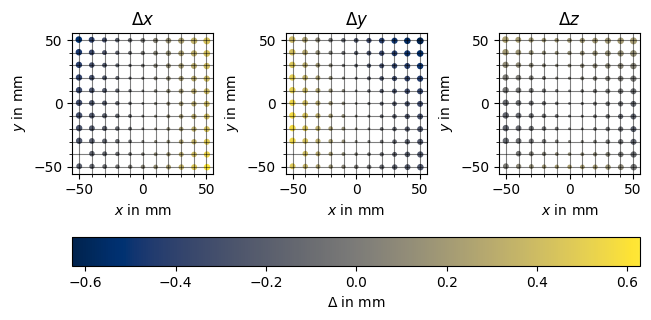

In [ ]:
import matplotlib.colors as mcolors

norm = mcolors.Normalize(
    vmin=min(np.min(xdist), np.min(ydist)),
    vmax=max(np.max(xdist), np.max(ydist)),
)

norm = mcolors.CenteredNorm(
    0, max(np.max(np.abs(xdist)), np.max(np.abs(ydist)))
)

total_dist = np.sqrt(np.array(xdist) ** 2 + np.array(ydist) ** 2 + z**2)


fig, ax = plt.subplots(
    1,
    3,
    sharex=True,
    layout="constrained",
    figsize=np.multiply(plt.rcParams["figure.figsize"], (1, 1)),
)

marker_scale_factor = 20
cmap = plt.cm.cividis

ax[0].scatter(
    xx,
    yy,
    c=xdist,
    cmap=cmap,
    norm=norm,
    s=marker_scale_factor * total_dist,
)
ax[1].scatter(
    xx,
    yy,
    c=ydist,
    cmap=cmap,
    norm=norm,
    s=marker_scale_factor * total_dist,
)
ax[2].scatter(
    xx, yy, c=z, cmap=cmap, norm=norm, s=marker_scale_factor * total_dist
)

[a.set_aspect("equal") for a in ax]

ax[0].set_title("$\Delta x$")
ax[1].set_title("$\Delta y$")
ax[2].set_title("$\Delta z$")

[a.set_ylabel(r"$y$ in mm") for a in ax]
[a.set_xlabel(r"$x$ in mm") for a in ax]

major_ticks = [-50, 0, 50]
minor_ticks = [-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50]
[a.set_xticks(major_ticks) for a in ax]
[a.set_xticks(minor_ticks, minor=True) for a in ax]
[a.set_yticks(major_ticks) for a in ax]
[a.set_yticks(minor_ticks, minor=True) for a in ax]
[a.grid(which="both", c="k", alpha=0.5) for a in ax]

cbar = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax,
    orientation="horizontal",
)
cbar.set_label("$\Delta$ in mm")

The discrete figure from above can also be visualized as a smooth contour by interpolating missing points:  

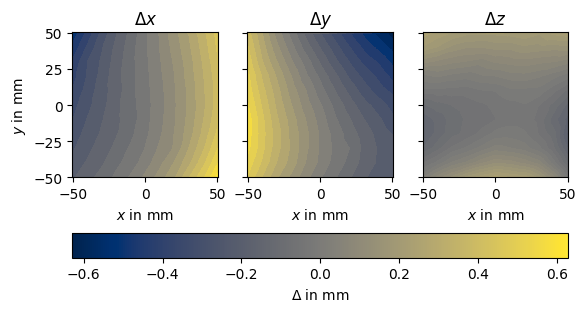

In [ ]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
ax[0].set_title(r"$\Delta x$")
ax[0].tricontourf(xx, yy, xdist, levels=20, norm=norm, cmap=cmap)
ax[1].set_title(r"$\Delta y$")
ax[1].tricontourf(xx, yy, ydist, levels=20, norm=norm, cmap=cmap)
ax[2].set_title(r"$\Delta z$")
ax[2].tricontourf(xx, yy, z, levels=20, norm=norm, cmap=cmap)

ax[0].set_ylabel(r"$y$ in mm")
[a.set_aspect("equal") for a in ax]
[a.set_xlabel(r"$x$ in mm") for a in ax]

cbar = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax,
    orientation="horizontal",
)
cbar.set_label("$\Delta$ in mm")